**Heteroskedasticity Testing, WLS:**  
   This part involves testing for heteroskedasticity to assess whether there's variance inconsistency in the model. Additionally, we employed Weighted Least Squares (WLS) to address this issue.

## Heteroskedasticity

In [ ]:

pip install statsmodels numpy pandas matplotlib seaborn


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.formula.api import ols

sns.set(style="whitegrid")

In [ ]:
pip install openpyxl

**Importing dataset**

In [ ]:
#Read data
file_path = r"C:\Users\ADMIN\Documents\FINAL-DATA.xlsx"
df = pd.read_excel(file_path)
df.head()

,Country Name,ISO,Year,Continent,Population (thousands),Life Expectancy (years),Ladder of life (Wellbeing) (0-10),Carbon Footprint (tCO2e),HPI,GDP per capita ($),Annual precipitation,Average years of schooling,Gini coefficient,GNI,Unemployment
0,Algeria,DZA,2011,Africa,36543.5,74.1,5.32,2.75,48.0,11114,82.46702,7.286604,0.276157,5050,9.96
1,Armenia,ARM,2011,Asia,2929.0,73.3,4.26,3.22,37.3,9551,953.70953,11.194550,0.293529,3360,18.44
2,Austria,AUT,2011,Europe,8391.2,80.8,7.47,14.52,44.1,53179,1024.22410,11.711150,0.308010,50700,4.56
3,Belarus,BLR,2011,Europe,9707.0,71.5,5.23,5.39,38.5,18274,635.04770,11.380924,0.271525,6350,6.17
4,Belgium,BEL,2011,Europe,10955.7,80.4,7.11,20.59,34.4,48155,788.48303,11.469870,0.280604,46370,7.14


**Data Cleaning** 

In [14]:
df = df.drop_duplicates()
df.shape

(619, 15)

In [15]:
df.isnull().sum()

Country Name                         0
ISO                                  0
Year                                 0
Continent                            0
Population (thousands)               0
Life Expectancy (years)              0
Ladder of life (Wellbeing) (0-10)    0
Carbon Footprint (tCO2e)             0
HPI                                  0
GDP per capita ($)                   0
Annual precipitation                 0
Average years of schooling           0
Gini coefficient                     0
GNI                                  0
Unemployment                         0
dtype: int64

**OLS Regression**

In [22]:
#Fit OLS model
X_vars = ['Population (thousands)', 'Life Expectancy (years)', 
          'Ladder of life (Wellbeing) (0-10)', 'Carbon Footprint (tCO2e)',
          'GDP per capita ($)', 'Annual precipitation', 
          'Average years of schooling', 'Gini coefficient']

X = df[X_vars]
X = sm.add_constant(X)
y = df['HPI']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     941.5
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:24:07   Log-Likelihood:                -1368.9
No. Observations:                 619   AIC:                             2756.
Df Residuals:                     610   BIC:                             2796.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

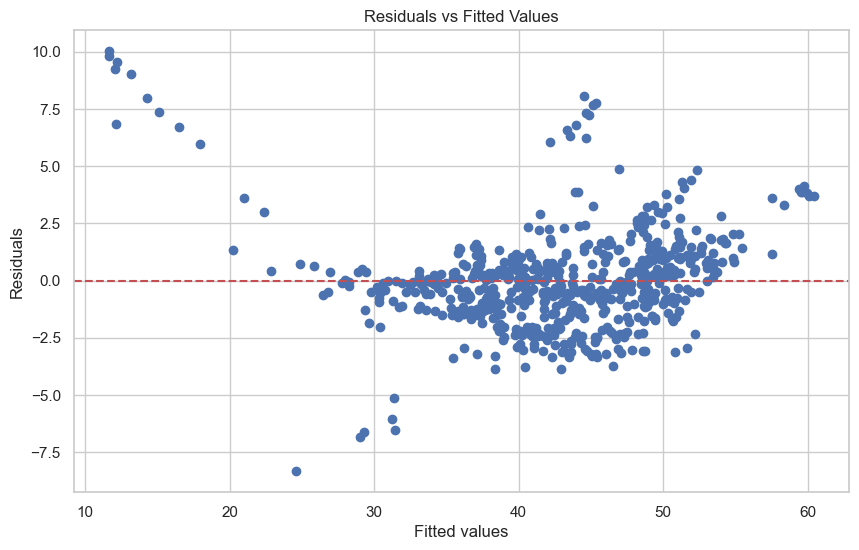

In [ ]:
# 1. Visual inspection of residuals
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

**Correlation values between each independent variable and the squared residuals**

In [ ]:
# Tạo DataFrame chứa bình phương phần dư và các biến độc lập
residual_analysis = pd.DataFrame()
residual_analysis['resid_squared'] = model.resid**2

# Tính hệ số tương quan
correlations = {}
for var in X_vars:
    residual_analysis[var] = df[var]
    corr = residual_analysis['resid_squared'].corr(residual_analysis[var])
    correlations[var] = corr

# Hiển thị kết quả tương quan
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
for var, corr in sorted_correlations:
    print(f"{var}: {corr:.4f}")


Carbon Footprint (tCO2e): 0.3176
GDP per capita ($): 0.2359
Life Expectancy (years): -0.1721
Population (thousands): -0.0870
Average years of schooling: -0.0751
Ladder of life (Wellbeing) (0-10): 0.0312
Gini coefficient: -0.0281
Annual precipitation: -0.0154


The final table presents the correlation values between each independent variable and the squared residuals. These values indicate the extent to which each variable contributes to heteroskedasticity in the model:

__1. Most Influential Variable:__
- Carbon Footprint: With the highest positive correlation coefficient (0.3176), this suggests that as the carbon footprint increases, the variance of errors also increases, contributing to the presence of heteroskedasticity.

__2. Moderately Influential Variables:__
- GDP per capita: A positive correlation of 0.2359 indicates that an increase in GDP may lead to greater variability in the errors, though this effect is weaker than that of Carbon Footprint.

__3. Weak or Opposite Influence:__
- Life Expectancy : Have negative correlation coefficients, indicating that an increase in life expectancy or population may reduce the variability in errors, suggesting these variables counteract heteroskedasticity.

__4. Other Variables:__
- These variables have minimal influence on heteroskedasticity, with correlation coefficients close to zero.

The **Carbon Footprint** and **GDP per capita** are the most notable variables that may increase heteroskedasticity in the model.

In [ ]:
#Breuch-Pagan test; for significant level of 0.05 
bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

Breusch-Pagan test:
{'Lagrange multiplier statistic': np.float64(244.20438489119164), 'p-value': np.float64(2.9135611523628114e-48), 'f-value': np.float64(49.681969578399546), 'f p-value': np.float64(1.0463412024906488e-61)}
Reject the null hypothesis of homoscedasticity


In [ ]:
#Breusch Pagan Test
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

# Kiểm định riêng lẻ cho từng biến
bp_results = {}
for var in X_vars:
    X_single = sm.add_constant(df[[var]])
    bp_test = het_breuschpagan(model.resid, X_single)
    bp_results[var] = bp_test[1]  # p-value

# Hiển thị kết quả theo thứ tự tăng dần của p-value
sorted_bp = sorted(bp_results.items(), key=lambda x: x[1])
for var, p_value in sorted_bp:
    significance = "Significant" if p_value < 0.05 else "Not significant"
    print(f"{var}: p-value = {p_value:.4f} ({significance})")

Carbon Footprint (tCO2e): p-value = 0.0000 (Significant)
GDP per capita ($): p-value = 0.0000 (Significant)
Life Expectancy (years): p-value = 0.0000 (Significant)
Population (thousands): p-value = 0.0303 (Significant)
Average years of schooling: p-value = 0.0618 (Not significant)
Ladder of life (Wellbeing) (0-10): p-value = 0.4371 (Not significant)
Gini coefficient: p-value = 0.4840 (Not significant)
Annual precipitation: p-value = 0.7018 (Not significant)


p-value Analysis for Heteroskedasticity:

If p-value < 0.05: This indicates the presence of heteroskedasticity (result: "Significant").

If p-value ≥ 0.05: There is not enough evidence to reject the null hypothesis (result: "Not significant").

**Analysis Conclusion:**
The analysis shows that variables such as Carbon Footprint, GDP per capita, Life Expectancy, and Population have a significant impact on heteroskedasticity. In contrast, other variables do not show a noticeable effect on the model.

In [ ]:
#White test; for significant level of 0.05 
white_test = sm.stats.diagnostic.het_white(model.resid,  model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\nWhite test:")
res = dict(zip(labels, white_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")
else: 
    print("Reject the null hypothesis of homoscedasticity")

không thể chạy While test do perfect multicolinearity

In [122]:
#Goldfeld-Quandt test; for significant level of 0.05
gq_test = sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
labels = ['F statistic', 'p-value']
print("\nGoldfeld-Quandt test:")
res = dict(zip(labels, gq_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")


Goldfeld-Quandt test:
{'F statistic': np.float64(0.9137766291828495), 'p-value': np.float64(0.7825020972222678)}


In [ ]:
#Goldfeld-Quandt Test
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Kiểm định Goldfeld-Quandt cho từng biến
gq_results = {}
for var in X_vars:
    # Sắp xếp dữ liệu theo biến đang xét
    sorted_data = df.sort_values(by=var)
    # Chia dữ liệu thành hai phần bỏ qua phần giữa
    n = len(sorted_data)
    subset_size = n // 3
    X1 = sm.add_constant(sorted_data[X_vars].iloc[:subset_size])
    X2 = sm.add_constant(sorted_data[X_vars].iloc[-subset_size:])
    y1 = sorted_data['HPI'].iloc[:subset_size]
    y2 = sorted_data['HPI'].iloc[-subset_size:]
    
    # Chạy hồi quy trên hai tập con
    model1 = sm.OLS(y1, X1).fit()
    model2 = sm.OLS(y2, X2).fit()
    
    # Tính tỷ lệ phương sai
    variance_ratio = np.var(model2.resid) / np.var(model1.resid)
    gq_results[var] = variance_ratio

# Hiển thị kết quả theo thứ tự tăng dần của variance ratio
sorted_gq = sorted(gq_results.items(), key=lambda x: abs(x[1]-1), reverse=True)
for var, ratio in sorted_gq:
    print(f"{var}: Variance ratio = {ratio:.4f}")

Carbon Footprint (tCO2e): Variance ratio = 7.7717
Average years of schooling: Variance ratio = 6.1705
Ladder of life (Wellbeing) (0-10): Variance ratio = 2.7842
Population (thousands): Variance ratio = 0.1110
Annual precipitation: Variance ratio = 0.1416
Gini coefficient: Variance ratio = 0.1475
GDP per capita ($): Variance ratio = 1.3212
Life Expectancy (years): Variance ratio = 1.2355


**Interpretation of the Variance Ratios**

__1. High Variance Ratios (Indicating Potential Heteroskedasticity):__

- Carbon Footprint (tCO₂e): Variance ratio = 7.7717

- Average Years of Schooling: Variance ratio = 6.1705

- These two variables have notably high variance ratios (both above 6), indicating that they likely contribute to heteroskedasticity in the model. This means the variance of errors increases significantly with changes in these variables, which could lead to inefficient and biased parameter estimates if not addressed.

__2. Moderate Variance Ratio (Some Heteroskedasticity):__

- Ladder of Life (Well-being) (0-10): Variance ratio = 2.7842
This variable shows a moderate variance ratio, suggesting that while it does contribute to heteroskedasticity, its effect is not as pronounced as Carbon Footprint or Average Years of Schooling. The level of heteroskedasticity here is present but weaker.

__3. Low Variance Ratios (Minimal or No Heteroskedasticity):__

- Other variables have low variance ratios (all under 2), indicating that they have little to no impact on heteroskedasticity in the model. The error variance remains relatively stable across different levels of these variables.

In [87]:
correlation_values = [correlations[var] for var in X_vars]
p_values = [bp_results[var] for var in X_vars]
ratios = [gq_results[var] for var in X_vars]
table1 = {
    'Variable': X_vars,
    'Correlation with Squared Residuals': [f"{corr:.4f}" for corr in correlation_values],
    'Breusch-Pagan p-value': [f"{p_value:.4f}" for p_value in p_values],
    'Goldfeld-Quandt Variance Ratio': [f"{variance_ratio:.4f}" for variance_ratio in ratios]
}

# Create DataFrame
df = pd.DataFrame(table1)
df

,Variable,Correlation with Squared Residuals,Breusch-Pagan p-value,Goldfeld-Quandt Variance Ratio
0,Population (thousands),-0.0870,0.0303,0.1110
1,Life Expectancy (years),-0.1721,0.0000,1.2355
2,Ladder of life (Wellbeing) (0-10),0.0312,0.4371,2.7842
3,Carbon Footprint (tCO2e),0.3176,0.0000,7.7717
4,GDP per capita ($),0.2359,0.0000,1.3212
5,Annual precipitation,-0.0154,0.7018,0.1416
6,Average years of schooling,-0.0751,0.0618,6.1705
7,Gini coefficient,-0.0281,0.4840,0.1475


**Conclusion**

Variables likely causing heteroskedasticity:

__1. Carbon Footprint (tCO₂e):__

Reason: It has the highest correlation with squared residuals, a significant p-value in the Breusch-Pagan test, and the highest variance ratio in the Goldfeld-Quandt test. This suggests that increasing carbon footprint increases the error variance, which creates heteroskedasticity.

__2. GDP per capita ($):__

Reason: This variable also shows a moderate correlation with squared residuals, a significant p-value, and a higher variance ratio. This suggests that increasing GDP per capita might contribute to varying error variance, indicating heteroskedasticity.

__3. Life Expectancy (years) and Population (thousands):__(?)

Reason: Both show significant results in the Breusch-Pagan test and have higher variance ratios, indicating they contribute moderately to heteroskedasticity.

To mitigate heteroskedasticity, consider addressing Carbon Footprint and GDP per capita through techniques like weighted least squares or transforming the variables. Since Life Expectancy and Population show moderate effects, it may be worth exploring potential adjustments for them as well.

## WLS 

In [136]:
## add a intercept point
w1 = model.fittedvalues

model_wls_1 = sm.WLS(y, X, weights = w1) 
mod_res_1 = model_wls_1.fit() 
print(mod_res_1.summary())

residuals = mod_res_1.resid
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, mod_res_1.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

                            WLS Regression Results                            
Dep. Variable:                    HPI   R-squared:                       0.941
Model:                            WLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     1207.
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        21:51:23   Log-Likelihood:                -1270.8
No. Observations:                 619   AIC:                             2560.
Df Residuals:                     610   BIC:                             2599.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

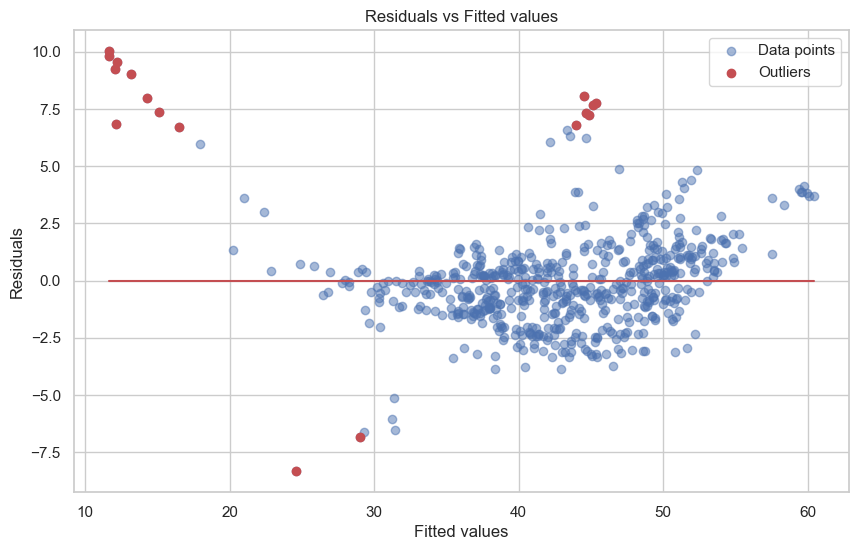

In [98]:
#Outlier detection 
# Calculate the z-scores of the residuals
import scipy.stats as stats
residuals = model.resid 
fitted = model.fittedvalues
z_scores = np.abs(stats.zscore(residuals))

# Define a threshold for outliers
threshold = 3

# Create a boolean mask for the outliers
outliers = z_scores > threshold

# Draw a plot
plt.figure(figsize=(10,6))
plt.scatter(fitted, residuals, alpha=0.5, label='Data points')
plt.scatter(fitted[outliers], residuals[outliers], color='r', label='Outliers')
plt.plot([fitted.min(), fitted.max()], [0, 0], 'r-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.legend()
plt.show()

In [135]:
#Creating a new df with removed outliers 

df['residuals'] = model.resid 
df_new = df.copy()
df_new['z_scores'] = np.abs(stats.zscore(df_new['residuals']))
df_new = df_new[df_new['z_scores'] < 3]
df_new = df_new.drop(columns = ['z_scores'])
len(df_new)

8

In [134]:
print(df_new)

                            Variable Correlation with Squared Residuals  \
0             Population (thousands)                            -0.0870   
1            Life Expectancy (years)                            -0.1721   
2  Ladder of life (Wellbeing) (0-10)                             0.0312   
3           Carbon Footprint (tCO2e)                             0.3176   
4                 GDP per capita ($)                             0.2359   
5               Annual precipitation                            -0.0154   
6         Average years of schooling                            -0.0751   
7                   Gini coefficient                            -0.0281   

  Breusch-Pagan p-value Goldfeld-Quandt Variance Ratio  residuals      temp  
0                0.0303                         0.1110   3.871253  3.871253  
1                0.0000                         1.2355   1.429164  1.429164  
2                0.4371                         2.7842  -2.204432  2.204432  
3           

In [ ]:
#Fitting the new df 
X = df_new[X_vars]
X = sm.add_constant(X) 
y = df_new['HPI'] 
model_new = sm.OLS(y, X).fit()
print(model_new.summary())

In [128]:
#Using the new model summary, we test again: 
bp_test = sm.stats.diagnostic.het_breuschpagan(model.resid, model.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("Breusch-Pagan test:")
res = dict(zip(labels, bp_test))
print(res)
if res['p-value'] < 0.05:
    print("Reject the null hypothesis of homoscedasticity")

Breusch-Pagan test:
{'Lagrange multiplier statistic': np.float64(244.20438489119164), 'p-value': np.float64(2.9135611523628114e-48), 'f-value': np.float64(49.681969578399546), 'f p-value': np.float64(1.0463412024906488e-61)}
Reject the null hypothesis of homoscedasticity
